# Module 6 - Brooke Powers

In [46]:
import numpy as np
import matplotlib.pyplot as plt


In [47]:
import openseespy.opensees as ops
import opsvis as opsv

### Moment-curvature analysis of Grade A992 W10x54 steel section

In [48]:
# Assumed units: kip, in, ksi

# Material properties
Fy = 50.0
Es = 29000.0
nu = 0.3
GJ = (0.5*Es/(1+nu))*1.82

# Section dimensions from Steel Manual
d = 10.1
bf = 10.0
tw = 0.370
tf = 0.615

S = 60
Z = 66.6

# Yield and plastic moment
My = Fy*S
Mp = Fy*Z

Sy = 20.6
Zy = 31.3

Myy = Fy*Sy
Mpy = Fy*Zy

In [49]:
def momentcurveanalysis(sec):
    ops.wipe()
    ops.model('basic','-ndm',2,'-ndf',3)

    ops.node(1,0.0,0.0)
    ops.node(2,0.0,0.0)

    ops.fix(1,1,1,1)
    ops.fix(2,0,1,0)

    epsY = Fy/Es
    epsMax = 0.01

    ops.uniaxialMaterial('ElasticPP',1,Es,epsY)
    
    if sec ==1:
        ops.section('WFSection2d',1,1,d,tw,bf,tf,10,2)
    elif sec == 2:

        ops.section('Fiber',1)
        ops.patch('rect',1,2,1,0.5*d,0.5*bf,0.5*d-tf,-0.5*bf) # Top flange
        ops.patch('rect',1,10,1,0.5*d-tf,0.5*tw,-0.5*d+tf,-0.5*tw) # Web
        ops.patch('rect',1,2,1,-0.5*d+tf,0.5*bf,-0.5*d,-0.5*bf) # Bottom flange
        
    ops.element('zeroLengthSection',1,1,2,1)

    y = -0.5*d # depth to extreme tension fiber
    e = ops.eleResponse(1,'section','deformation')
    eps = e[0] - y*e[1]

    ops.timeSeries('Linear',2)
    ops.pattern('Plain',2,2)
    ops.load(2,0.0,0.0,1.0) #moment of 1

    deps = 0.01*epsY
    ops.integrator('DisplacementControl',2,3,deps)

    ops.algorithm('Newton')
    ops.constraints('Transformation')
    ops.numberer('RCM')
    ops.system('Umfpack')
    ops.analysis('Static')

    Mplot = np.zeros(1)
    Kplot = np.zeros(1)

    while eps < epsMax:
        ok = ops.analyze(1)
        if ok < 0:
            break

        e = ops.eleResponse(1,'section','deformation')
        eps = e[0] - y*e[1]

        Mplot = np.append(Mplot,ops.getLoadFactor(2))
        Kplot = np.append(Kplot,e[1])
        if Kplot[len(Kplot)-1] >= 0.00036 and Kplot[len(Kplot)-2] <= 0.00036:
            Myo = ops.getLoadFactor(2);
            
    plt.figure()
    plt.plot(Kplot,Mplot)
    plt.axhline(My, color='b', linestyle='-',label='Myx')
    plt.axhline(Mp, color='r', linestyle='-',label='Mpx')
    plt.xlabel('Curvature (1/in)')
    plt.ylabel('Moment (kip-in)')
    plt.title('Grade A992 W10x54')
    plt.legend()
    plt.grid()
    plt.show()
    print(sec)
 
    print(f'AISC Manual Yield Moment ={My} kip-in and Plastic Moment ={round(Mp,1)} kip-in')
    print(f'OpenSees Calcualted Yield Moment ={round(Myo,1)} kip-in and Plastic Moment ={round(ops.getLoadFactor(2),1)} kip-in')

    print(f'Raito of OpenSees Calcualted Yield Moment to AISC Manual Yield Moment ={round(My/Myo,2)*100} % and Plastic Moment = {round(Mp/ops.getLoadFactor(2),2)*100} %')


### 1. Strong axis bending (about the z axis) with fibers defined through the WFSection2d command.

### verify that the yield and plastic moments match values tabulated in the AISC Steel Manual

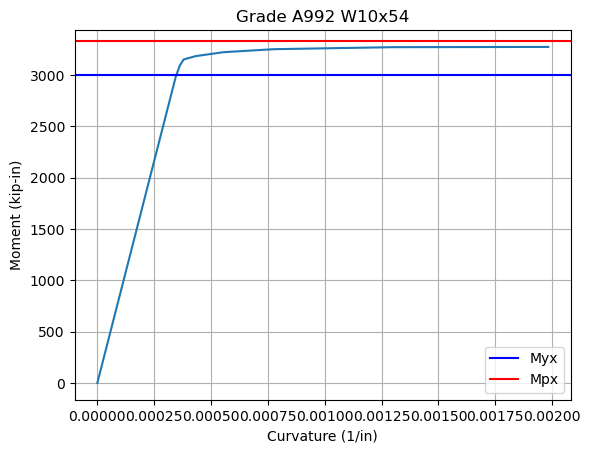

1
AISC Manual Yield Moment =3000.0 kip-in and Plastic Moment =3330.0 kip-in
OpenSees Calcualted Yield Moment =3089.0 kip-in and Plastic Moment =3273.4 kip-in
Raito of OpenSees Calcualted Yield Moment to AISC Manual Yield Moment =97.0 % and Plastic Moment = 102.0 %


In [50]:
momentcurveanalysis(1) # using WFSection2d command

In [51]:
# The difference in the moments pulled from AISC versus per openSees is less than 3% 
# for both the yield and plastic moments using the WFSection2d command.

### 2. Strong axis bending with fibers defined using the patch command. 

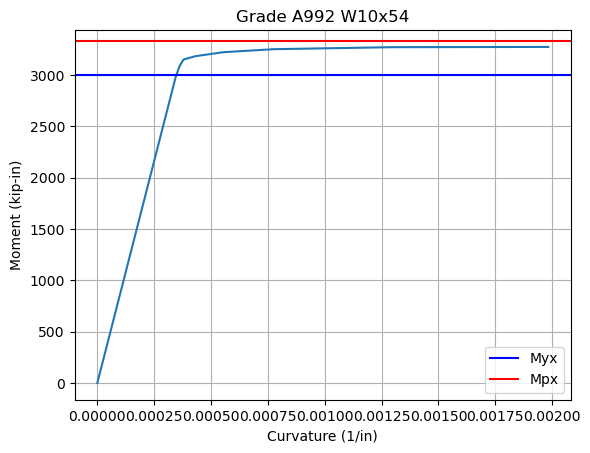

2
AISC Manual Yield Moment =3000.0 kip-in and Plastic Moment =3330.0 kip-in
OpenSees Calcualted Yield Moment =3089.0 kip-in and Plastic Moment =3273.4 kip-in
Raito of OpenSees Calcualted Yield Moment to AISC Manual Yield Moment =97.0 % and Plastic Moment = 102.0 %


In [52]:
momentcurveanalysis(2) # using patch command

In [53]:
# The difference in the moments pulled from AISC versus per openSees is less than 3% 
# for both the yield and plastic moments using the WFSection2d command.
# The results for the WFSectio2d command and the patch command have the same results

### 3. Weak axis bending with the section discretized along both the y and z axes using the patch command. Also define a torsional stiffness, GJ, for the fiber section.

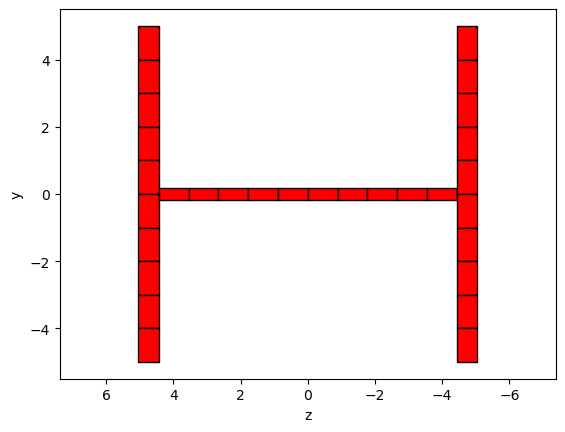

DisplacementControl::newStep(void) - failed in solver
StaticAnalysis::analyze() - the Integrator failed at step: 0 with domain at load factor 0
OpenSees > analyze failed, returned: -2 error flag


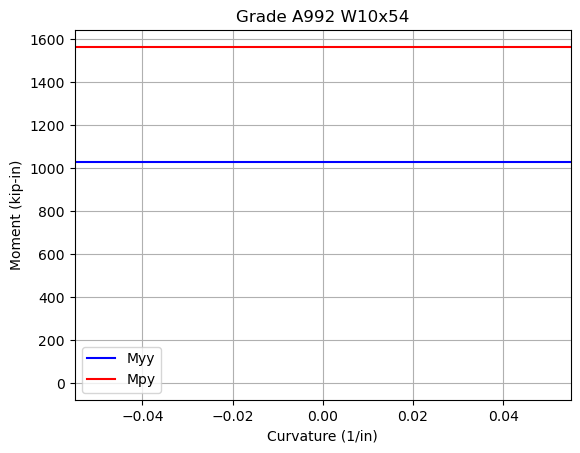

AISC Manual Yield Moment =1030.0 kip-in and Plastic Moment =1565.0 kip-in


NameError: name 'Myo' is not defined

In [54]:
ops.wipe()
ops.model('basic','-ndm',3,'-ndf',6) # 3D

ops.node(1,0.0,0.0,0.0)
ops.node(2,0.0,0.0,0.0)
# need to convert everythig below to 3D
ops.fix(1,1,1,1,1,1,1)
ops.fix(2,1,1,0,0,0,0)

epsY = Fy/Es
epsMax = 0.01

ops.uniaxialMaterial('ElasticPP',1,Es,epsY)


fib_sec_1 = [['section', 'Fiber', 1, '-GJ', GJ],
     ['patch', 'rect',1,10,1,0.5*bf,0.5*d,-0.5*bf,0.5*d-tf],   # Top flange
     ['patch', 'rect',1,1,10,0.5*tw,0.5*d-tf,-0.5*tw,-0.5*d+tf],  # Web
     ['patch', 'rect',1,10,1,0.5*bf,-0.5*d+tf,-0.5*bf,-0.5*d] # Bottom flange
     ]

opsv.fib_sec_list_to_cmds(fib_sec_1)
matcolor = ['r', 'lightgrey', 'gold', 'w', 'w', 'w']
opsv.plot_fiber_section(fib_sec_1, matcolor=matcolor)
plt.axis('equal')
plt.show()


ops.element('zeroLengthSection',1,1,2,1)

y = -0.5*bf # depth to extreme tension fiber
e = ops.eleResponse(1,'section','deformation')
eps = e[0] - y*e[1]

ops.timeSeries('Linear',2)
ops.pattern('Plain',2,2)
ops.load(2,0.0,0.0,0.0,0.0,1.0,0.0) #moment @ DOF5

deps = 0.01*epsY
ops.integrator('DisplacementControl',2,5,deps) # the 3 was a 6

ops.algorithm('Newton')
ops.constraints('Plain')
ops.numberer('Plain')
ops.system('Umfpack')
ops.analysis('Static')

Mplot = np.zeros(1)
Kplot = np.zeros(1)

while eps < epsMax:
    ok = ops.analyze(1)
    if ok < 0:
        break

    e = ops.eleResponse(1,'section','deformation')
    eps = e[0] - y*e[1]

    Mplot = np.append(Mplot,ops.getLoadFactor(2))
    Kplot = np.append(Kplot,e[1])
    if Kplot[len(Kplot)-1] >= 0.00036 and Kplot[len(Kplot)-2] <= 0.00036:
        Myo = ops.getLoadFactor(2);

plt.figure()
plt.plot(Kplot,Mplot)
plt.axhline(Myy, color='b', linestyle='-',label='Myy')
plt.axhline(Mpy, color='r', linestyle='-',label='Mpy')
plt.xlabel('Curvature (1/in)')
plt.ylabel('Moment (kip-in)')
plt.title('Grade A992 W10x54')
plt.legend()
plt.grid()
plt.show()

print(f'AISC Manual Yield Moment ={Myy} kip-in and Plastic Moment ={round(Mpy,1)} kip-in')
print(f'OpenSees Calcualted Yield Moment ={round(Myo,1)} kip-in and Plastic Moment ={round(ops.getLoadFactor(2),1)} kip-in')

print(f'Raito of OpenSees Calcualted Yield Moment to AISC Manual Yield Moment ={round(Myy/Myo,2)*100} % and Plastic Moment = {round(Mpy/ops.getLoadFactor(2),2)*100} %')

